# Plot of the conditional probability of overshoot and joint Tb-Tcp histograms

In [1]:
import pickle

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

from matplotlib import cm
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


In [2]:
file_path = "/work/bb1153/b380887/big_obs_climo/"
save_dir = "/home/b/b380887/cold-point-overshoot/plots/obs_paper/paper_figs/"
hist_pickle_dir = "/home/b/b380887/cold-point-overshoot/pickle_files/climo_tb_cp_hists//"
prob_pickle_dir = "/home/b/b380887/cold-point-overshoot/pickle_files/cond_probs/"


In [3]:
# False to make the supporting information plots
main_text = False


In [4]:
if main_text:
    region_dict = {
        "DJF": ["AMZ", "SPC"],
        "JJA": ["AFR", "WPC"]
    }

else:
    region_dict = {
        "DJF": ["IOS", "ECP"],
        "JJA": ["IOE", "ECP"]
    }


### Get the joint climatology histogram

In [5]:
year_list = [2007, 2008, 2009, 2010]
years_str = str(year_list[0]) + "-" + str(year_list[-1])
print(years_str)


2007-2010


In [6]:
# dictionary mapping season to hist_region_dict
season_hist_dict = {}


In [7]:
for season in list(region_dict.keys()):
    # dictionary mapping regions to histogram values
    hist_region_dict = {}
    
    for region in region_dict[season]:
        hist_computed_list = [[]]*len(year_list)
        nan_len_list = [[]]*len(year_list)

        for i, year in enumerate(year_list):
            if region == "SPC":
                with open(hist_pickle_dir + "Tb-cpT_hist_dict_{s}{y}_{r}1.pickle".format(s=season, y=year, r=region), "rb") as handle:
                    hist_dict_yr_1 = pickle.load(handle) 
                with open(hist_pickle_dir + "Tb-cpT_hist_dict_{s}{y}_{r}2.pickle".format(s=season, y=year, r=region), "rb") as handle:
                    hist_dict_yr_2 = pickle.load(handle)
                hist_computed_list[i] = np.sum([hist_dict_yr_1["hist_computed"], hist_dict_yr_2["hist_computed"]], axis=0)
                nan_len_list[i] = hist_dict_yr_1["nan_len"] + hist_dict_yr_2["nan_len"]
            else:
                with open(hist_pickle_dir + "Tb-cpT_hist_dict_{s}{y}_{r}.pickle".format(s=season, y=year, r=region), "rb") as handle:
                    hist_dict_yr = pickle.load(handle)
                hist_computed_list[i] = hist_dict_yr["hist_computed"]
                nan_len_list[i] = hist_dict_yr["nan_len"]

        # sum across years
        nan_len = sum(nan_len_list)
        hist_computed = np.sum(hist_computed_list, axis=0)

        # take bins & edges from the last dict in list
        hist_dict = {
            "hist_computed": hist_computed, 
            "xedges": hist_dict_yr["xedges"], 
            "yedges": hist_dict_yr["yedges"], 
            "tb_bins": hist_dict_yr["tb_bins"], 
            "cpT_bins": hist_dict_yr["cpT_bins"],
            "nan_len": nan_len,
        }

        hist_region_dict[region] = hist_dict
        
    season_hist_dict[season] = hist_region_dict
    


### Get the conditional probabilities
Probability of having IWC > minimum at 500m (and 300m, for WPC only) above the cold point at a given (Tb - Tcp) value

In [8]:
# Tb - Tcp bins
diff_bins = np.arange(-20, 51, 2)

# min detectable IWC threshold
min_iwc = 1e-7


In [9]:
# dictionaries mapping season to the regional probability dictionaries
season_prob500_dict = {}
season_prob300_dict = {}


#### Make & save the dictionaries (if not done yet)
This can take a while (~11-12 min)

In [10]:
%%time

for season in list(region_dict.keys()):
    prob500_dict = {}
    prob300_dict = {}

    for region in region_dict[season]:
        iwc500_list = [[]]*len(year_list)
        if region == "WPC":
            iwc300_list = [[]]*len(year_list)
        tb_list = [[]]*len(year_list)
        cpT_list = [[]]*len(year_list)

        for i, year in enumerate(year_list):
            if region == "SPC":
                iwc500_1 = xr.open_dataset(file_path + "{s}/DARDAR_cp_relative_iwc_{s}{y}_{r}1.nc".format(s=season, y=year, r=region))["iwc_a500"]
                iwc500_2 = xr.open_dataset(file_path + "{s}/DARDAR_cp_relative_iwc_{s}{y}_{r}2.nc".format(s=season, y=year, r=region))["iwc_a500"] 

                temp_1 = xr.open_dataset(file_path + "{s}/ERA5_T_0.25deg_ml_12-20km_{s}{y}_{r}1.nc".format(s=season, y=year, r=region))["t"]
                temp_2 = xr.open_dataset(file_path + "{s}/ERA5_T_0.25deg_ml_12-20km_{s}{y}_{r}2.nc".format(s=season, y=year, r=region))["t"]
                cpT_inds_1 = temp_1.chunk("auto").argmin(dim="level").compute()
                cpT_inds_2 = temp_2.chunk("auto").argmin(dim="level").compute()
                cpT_1 = temp_1.isel(level=cpT_inds_1).sel(time=iwc500_1.time, latitude=iwc500_1.lat, longitude=iwc500_1.lon, method="nearest")
                cpT_2 = temp_2.isel(level=cpT_inds_2).sel(time=iwc500_2.time, latitude=iwc500_2.lat, longitude=iwc500_2.lon, method="nearest")

                tb_1 = xr.open_dataset(file_path + "{s}/MERGIR_Tb_4km_{s}{y}_{r}1.nc4".format(s=season, y=year, r=region))
                tb_2 = xr.open_dataset(file_path + "{s}/MERGIR_Tb_4km_{s}{y}_{r}2.nc4".format(s=season, y=year, r=region))

                tb_dar_1 = tb_1["Tb"].sel(time=iwc500_1.time, lat=iwc500_1.lat, lon=iwc500_1.lon, method="nearest")
                tb_dar_2 = tb_2["Tb"].sel(time=iwc500_2.time, lat=iwc500_2.lat, lon=iwc500_2.lon, method="nearest")

                iwc500_list[i] = xr.concat([iwc500_1, iwc500_2], dim="time")
                tb_list[i] = xr.concat([tb_dar_1, tb_dar_2], dim="time")
                cpT_list[i] = xr.concat([cpT_1, cpT_2], dim="time")

            else:
                iwc500 = xr.open_dataset(file_path + "{s}/DARDAR_cp_relative_iwc_{s}{y}_{r}.nc".format(s=season, y=year, r=region))["iwc_a500"]
                temp = xr.open_dataset(file_path + "{s}/ERA5_T_0.25deg_ml_12-20km_{s}{y}_{r}.nc".format(s=season, r=region, y=year))["t"]
                cpT_inds = temp.chunk("auto").argmin(dim="level").compute()
                cpT = temp.isel(level=cpT_inds).sel(time=iwc500.time, latitude=iwc500.lat, longitude=iwc500.lon, method="nearest")
                tb = xr.open_dataset(file_path + "{s}/MERGIR_Tb_4km_{s}{y}_{r}.nc4".format(s=season, y=year, r=region))
                cpT_list[i] = cpT
                tb_list[i] = tb["Tb"].sel(time=iwc500.time, lat=iwc500.lat, lon=iwc500.lon, method="nearest")
                iwc500_list[i] = iwc500

                # also get CP+300m for WPC only
                if region == "WPC":
                    dar = xr.open_dataset(file_path + "{s}/DARDAR-v3_iwc_{s}{y}_{r}.nc".format(s=season, y=year, r=region))["iwc"]
                    cpz = xr.open_dataset(file_path + "{s}/DARDAR_cp_relative_iwc_{s}{y}_{r}.nc".format(s=season, y=year, r=region))["height_cp"]
                    iwc300_list[i] = dar.sel(height=(cpz+300.), method="nearest")

        # combine IWC data arrays over time
        iwc500 = xr.concat(iwc500_list, dim="time")
        if region == "WPC": 
            iwc300 = xr.concat(iwc300_list, dim="time")

        # combine the other data arrays over time
        cpT = xr.concat(cpT_list, dim="time")
        tb = xr.concat(tb_list, dim="time")

        # calculate the probabilities
        diffs = tb - cpT.values
        diffs_binned = diffs.groupby_bins(diffs, bins=diff_bins)
        diff_counts = diffs_binned.count()

        # bin ice > min by the tb difference bins
        iwc500_nz = iwc500.where(iwc500 > min_iwc)
        iwc500_nz_binned = iwc500_nz.assign_coords(time=diffs.time).groupby_bins(diffs, bins=diff_bins)
        prob500_dict[region] = iwc500_nz_binned.count() / diff_counts

        if region == "WPC": 
            iwc300_nz = iwc300.where(iwc300 > min_iwc)
            iwc300_nz_binned = iwc300_nz.assign_coords(time=diffs.time).groupby_bins(diffs, bins=diff_bins)
            prob300_dict[region] = iwc300_nz_binned.count() / diff_counts
        else:
            prob300_dict[region] = None
        print(region, "done")
            
    season_prob500_dict[season] = prob500_dict
    season_prob300_dict[season] = prob300_dict
    print(season, "done\n")


IOS done
ECP done
DJF done

IOE done
ECP done
JJA done

CPU times: user 3min 11s, sys: 2min 22s, total: 5min 33s
Wall time: 13min 11s


##### Save the DJF and JJA dictionaries (two regions/one season per file); 



In [12]:
for season in list(region_dict.keys()):
    regions = region_dict[season]
    regions_str = regions[0] + "_" + regions[1]
    out_name_500 = "cond_prob_iwc_above_500m_{s}{y}_{r}.pickle".format(s=season, y=years_str, r=regions_str)
    out_name_300 = "cond_prob_iwc_above_300m_{s}{y}_{r}.pickle".format(s=season, y=years_str, r=regions_str)

    with open(prob_pickle_dir + out_name_500, "wb") as handle:
        pickle.dump(season_prob500_dict[season], handle)
    print("dict saved to", out_name_500)

    with open(prob_pickle_dir + out_name_300, "wb") as handle:
        pickle.dump(season_prob300_dict[season], handle)
    print("dict saved to", out_name_300)


dict saved to cond_prob_iwc_above_500m_DJF2007-2010_IOS_ECP.pickle
dict saved to cond_prob_iwc_above_300m_DJF2007-2010_IOS_ECP.pickle
dict saved to cond_prob_iwc_above_500m_JJA2007-2010_IOE_ECP.pickle
dict saved to cond_prob_iwc_above_300m_JJA2007-2010_IOE_ECP.pickle


#### Load the conditional probability dictionaries if needed

In [13]:
for season in list(region_dict.keys()):
    regions = region_dict[season]
    regions_str = regions[0] + "_" + regions[1]
    out_name_500 = "cond_prob_iwc_above_500m_{s}{y}_{r}.pickle".format(s=season, y=years_str, r=regions_str)
    out_name_300 = "cond_prob_iwc_above_300m_{s}{y}_{r}.pickle".format(s=season, y=years_str, r=regions_str)

    with open(prob_pickle_dir + out_name_500, "rb") as handle:
        season_prob500_dict[season] = pickle.load(handle)

    with open(prob_pickle_dir + out_name_300, "rb") as handle:
        season_prob300_dict[season] = pickle.load(handle)


## Make the plots

##### Function to plot the conditional probability

In [14]:
def plot_cond_prob(ax, prob500, prob300, diff_bins, fsize, labsize,
                   ylim=(0, 100), gridlines=True):
    """ Plot panel for probability of overshoot for single region
    """
    avg_diff_bins = 0.5*(diff_bins[:-1] + diff_bins[1:])
    xlim = (diff_bins[0], diff_bins[-1])
    if gridlines:
        ax.grid(linestyle=":", color="gray")

    # 50% and Tb=Tcp lines
    ax.axvline(0, color="k", linewidth=2)
    ax.axhline(50, color="k", linestyle="--")

    # IWC +500m
    ax.scatter(avg_diff_bins, prob500.values*100., color="C0")
    ax.plot(avg_diff_bins, prob500.values*100., color="C0")

    # IWC +300m
    if prob300 is not None:
        ax.scatter(avg_diff_bins, prob300.values*100., marker="s", color="C2")
        ax.plot(avg_diff_bins, prob300.values*100., color="C2", linewidth=1)

    ax.set_ylim(ylim)
    ax.set_xlim(xlim)
    ax.set_xlabel("$T_b - T_{CP}$ (K)", fontsize=fsize)
    ax.set_ylabel("Probability of overshoot (%)", fontsize=fsize)
    ax.tick_params(axis="both", labelsize=labsize)


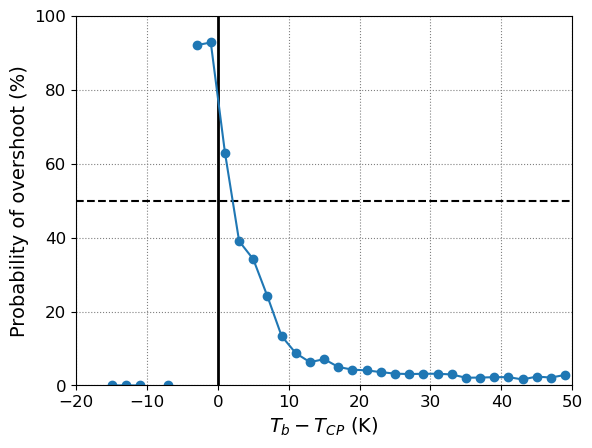

In [201]:
# quick test
prob500 = season_prob500_dict["DJF"]["SPC"]
prob300 = season_prob300_dict["DJF"]["SPC"]
fig, ax = plt.subplots()
plot_cond_prob(ax, prob500, prob300, diff_bins, fsize=14, labsize=12)
plt.show()

##### Function to plot the joint histogram

In [15]:
def plot_joint_hist(ax, hist_dict, fsize, labsize, colormap=cm.gist_earth_r,
               levels=np.arange(-6, -1), gridlines=True, show_colorbar=True):
    """ 
    Plot joint brightness temperature-cold point histogram for a single region.
    """
    nan_len = hist_dict["nan_len"]
    hist_computed = hist_dict["hist_computed"]
    xedges = hist_dict["xedges"]
    yedges = hist_dict["yedges"]
    tb_bins = hist_dict["tb_bins"]
    cpT_bins = hist_dict["cpT_bins"]

    hist_normed = hist_computed/nan_len # normalized bin count
    xbin_means, ybin_means = (xedges[:-1]+xedges[1:])/2, (yedges[:-1]+yedges[1:])/2
    hist_normed_nonzero = np.where(hist_normed > 0, hist_normed, np.nan)

    if gridlines:
        ax.grid(linestyle=":", color="gray")

    if levels is None:
        csn = ax.contourf(xbin_means, ybin_means, np.log10(hist_normed_nonzero.T), extend='both',
                         cmap=colormap)
    else:
        csn = ax.contourf(xbin_means, ybin_means, np.log10(hist_normed_nonzero.T), extend='both', levels=levels, 
                          vmin=levels[0], vmax=levels[-1], cmap=colormap)
    ax.contour(csn, colors='k', linestyles='solid', linewidths=1) # to add the black lines to outline the contours
    
    if show_colorbar:
        cb = plt.colorbar(csn, ax=ax)
        cb.set_label("log$_{10}$(PDF)", fontsize=fsize-1)
        cb.ax.tick_params(axis="y", labelsize=labsize)
        
    ax.set_xlabel("$T_{CP}$ (K)", fontsize=fsize)
    ax.set_ylabel("$T_b$ (K)", fontsize=fsize)
    ax.tick_params(axis="both", labelsize=labsize)
    ax.set_ylim((tb_bins[0], tb_bins[-1]))
    ax.set_xlim((cpT_bins[0], cpT_bins[-1]))
    
    # Tb=Tcp line
    ax.plot(cpT_bins, cpT_bins, color="k", linewidth=2)
    
    return csn


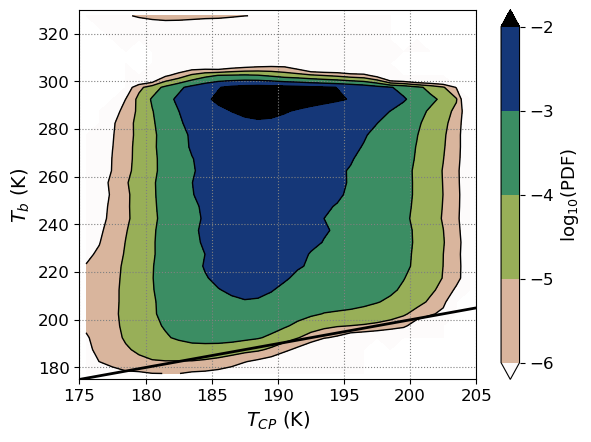

In [203]:
# quick test
hist_dict = season_hist_dict["DJF"]["SPC"]
fig, ax = plt.subplots()
plot_joint_hist(ax, hist_dict, fsize=14, labsize=12)
plt.show()


### Plot all panels together on one figure

In [16]:
def plot_prob_hist(season_hist_dict, season_prob500_dict, season_prob300_dict, diff_bins,
                   years_str, figsize=(32, 16), fsize=27, tsize=35, labsize=20, save=False):
    """ 
    Plot combined figure for 2 seasons (2 regions each) with conditional
    probability plots on the top row, joint histograms on the bottom, and a
    single key (proxy artist legend).
    """
    seasons = list(season_hist_dict.keys())
    all_regions = list(season_hist_dict[seasons[0]].keys()) + list(season_hist_dict[seasons[1]].keys())
    
    fig = plt.figure(figsize=figsize)
    gs = GridSpec(3, 23, figure=fig, height_ratios=[0.25, 5, 6], hspace=0.5, wspace=0.5)

    ax_title_left = fig.add_subplot(gs[0, :10])
    ax_title_right = fig.add_subplot(gs[0, 10:20])
    
    prob_axes = [
            fig.add_subplot(gs[1, :5]),
            fig.add_subplot(gs[1, 5:10]),
            fig.add_subplot(gs[1, 10:15]),
            fig.add_subplot(gs[1, 15:20]),
    ]
    hist_axes = [
            fig.add_subplot(gs[2, :5]),
            fig.add_subplot(gs[2, 5:10]),
            fig.add_subplot(gs[2, 10:15]),
            fig.add_subplot(gs[2, 15:20]),
    ]
    ax_leg = fig.add_subplot(gs[1, 20:])
    ax_cb = fig.add_subplot(gs[2, 20:])    
    
    # --- plot probabilities ----
    for i, region in enumerate(all_regions[:2]):
        plot_cond_prob(prob_axes[i], 
                       season_prob500_dict[seasons[0]][region], 
                       season_prob300_dict[seasons[0]][region], 
                       diff_bins, fsize=fsize, labsize=labsize, ylim=(-2, 102)
                      )
    for i, region in enumerate(all_regions[2:]):
        plot_cond_prob(prob_axes[i+2], 
                       season_prob500_dict[seasons[1]][region], 
                       season_prob300_dict[seasons[1]][region], 
                       diff_bins, fsize=fsize, labsize=labsize, ylim=(-2, 102)
               )
        
        
    # --- plot histograms ----
    for i, region in enumerate(all_regions[:2]):
        csn = plot_joint_hist(hist_axes[i], 
                        season_hist_dict[seasons[0]][region],
                        fsize=fsize, labsize=labsize, show_colorbar=False
                       )
    for i, region in enumerate(all_regions[2:]):
        csn = plot_joint_hist(hist_axes[i+2], 
                        season_hist_dict[seasons[1]][region],
                        fsize=fsize, labsize=labsize, show_colorbar=False
                       )


    # set yticks & lengthen so they're more visible
    for ax in prob_axes:
        prob_yticks = np.arange(0, 101, 20)
        ax.set_yticks(prob_yticks)
        ax.tick_params(axis="both", which='major', length=10)
    for ax in hist_axes:
        hist_yticks = np.arange(180, 321, 20)
        hist_xticks = np.arange(175, 205, 5)
        ax.set_yticks(hist_yticks)
        ax.set_xticks(hist_xticks)
        ax.tick_params(axis="both", which='major', length=10)
        
    # no y axis label or tick labels on the inner plots
    for ax in prob_axes[1:]:
        ax.set_ylabel("")
        ax.set_yticklabels([""]*len(prob_yticks))
    for ax in hist_axes[1:]:
        ax.set_ylabel("")
        ax.set_yticklabels([""]*len(hist_yticks)) 
    
            
    # plot titles
    ax_title_left.axis("off")
    ax_title_left.text(x=0.5, y=0, s="{s} {y}".format(s=seasons[0], y=years_str.replace("-", "—")), verticalalignment="center",
                  horizontalalignment="center", fontsize=tsize+5
                  )
    ax_title_right.axis("off")
    ax_title_right.text(x=0.5, y=0, s="{s} {y}".format(s=seasons[1], y=years_str.replace("-", "—")), verticalalignment="center",
                  horizontalalignment="center", fontsize=tsize+5
                  )
    
    # add region titles
    for i, region in enumerate(all_regions):
        prob_axes[i].set_title(region, fontsize=tsize)
        
        
    # proxy artist legend
    blue_line = mlines.Line2D([], [], color="C0", marker="o", 
                          label="CP + 500m")
    green_line = mlines.Line2D([], [], color="C2", marker="s", linestyle="-",
                               linewidth=1, label="CP + 300m")
    solid_line = mlines.Line2D([], [], color="k", linewidth=2,
                              label="$T_b=T_{CP}$")
    dashed_line = mlines.Line2D([], [], color="k", linestyle="--",
                                label="50% probability")
    ax_leg.legend(handles=[blue_line, green_line, dashed_line, solid_line],
                  ncol=1, fontsize=fsize, loc="lower left")
    ax_leg.axis("off")
    
    # colorbar for histograms
    axins = inset_axes(ax_cb, width="20%", height="100%", loc="center left")
    ax_cb.axis("off")
    cb = plt.colorbar(csn, cax=axins, orientation="vertical")        
    cb.set_label("log$_{10}$(PDF)", fontsize=fsize-1)
    cb.ax.tick_params(axis="y", labelsize=labsize)
    
    if save:
        if main_text:
            fig_name = save_dir + "cond_prob_joint_hists_main.png"
        else:
            fig_name = save_dir + "cond_prob_joint_hists_SI.png"
        plt.savefig(fig_name, dpi=300, bbox_inches="tight")
        print("saved to", fig_name)
    
    plt.show()
    

saved to /home/b/b380887/cold-point-overshoot/plots/obs_paper/paper_figs/cond_prob_joint_hists_main.png


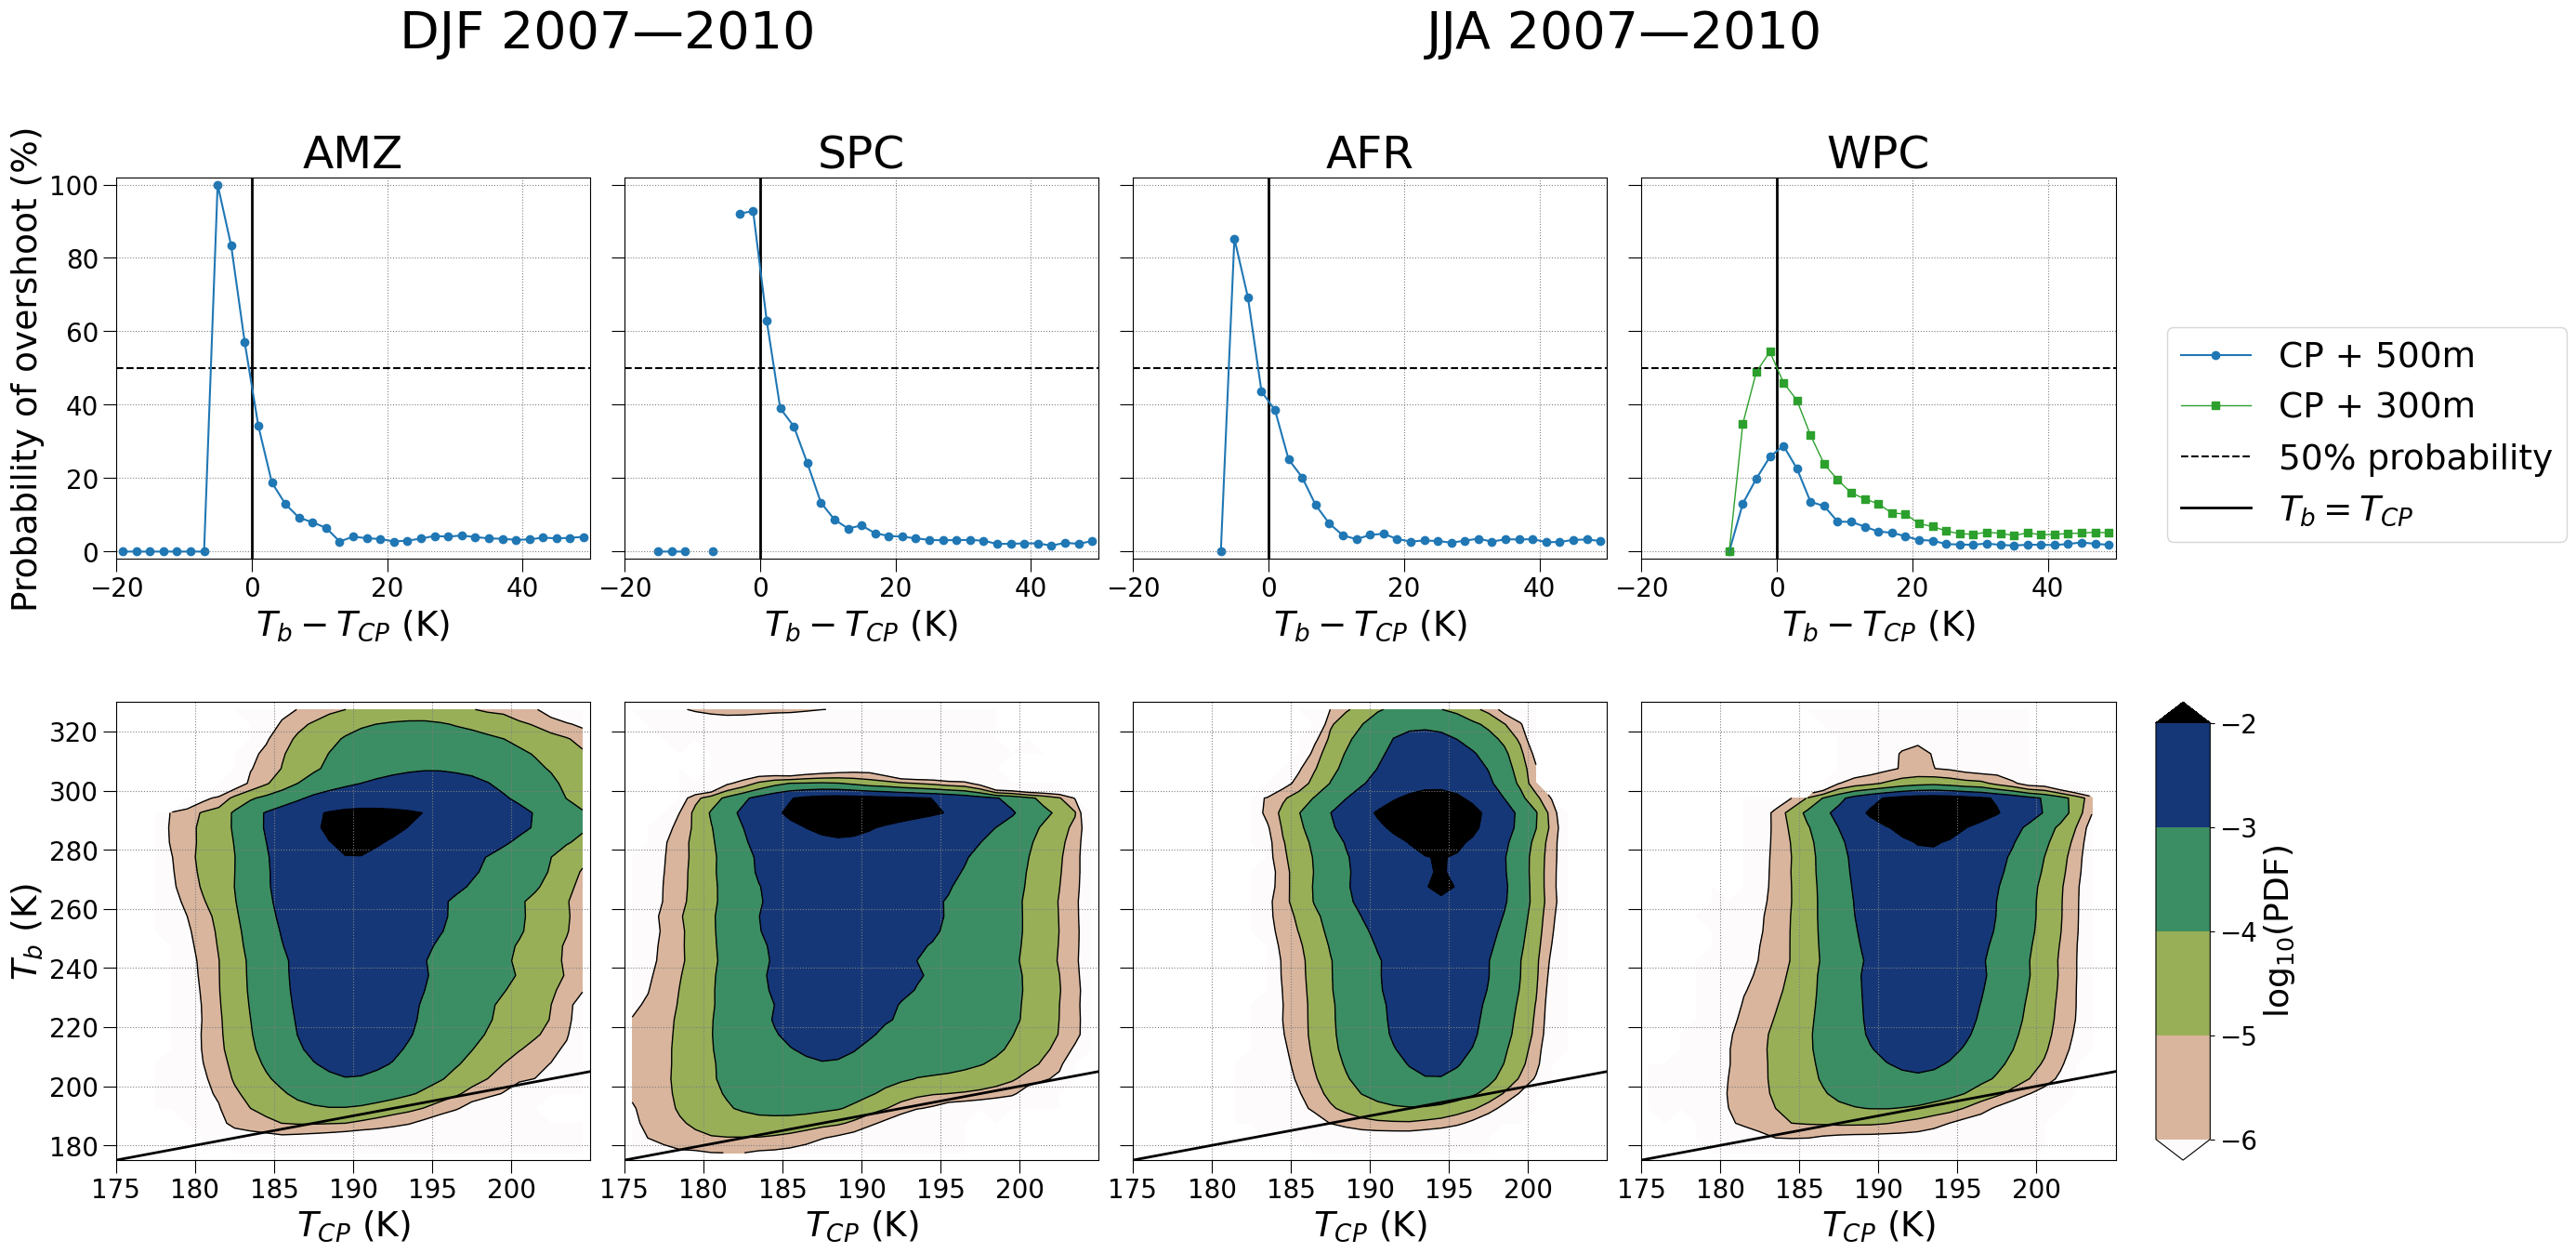

In [247]:
# main text
plot_prob_hist(season_hist_dict, season_prob500_dict, season_prob300_dict,
               diff_bins, years_str, save=True)


saved to /home/b/b380887/cold-point-overshoot/plots/obs_paper/paper_figs/cond_prob_joint_hists_SI.png


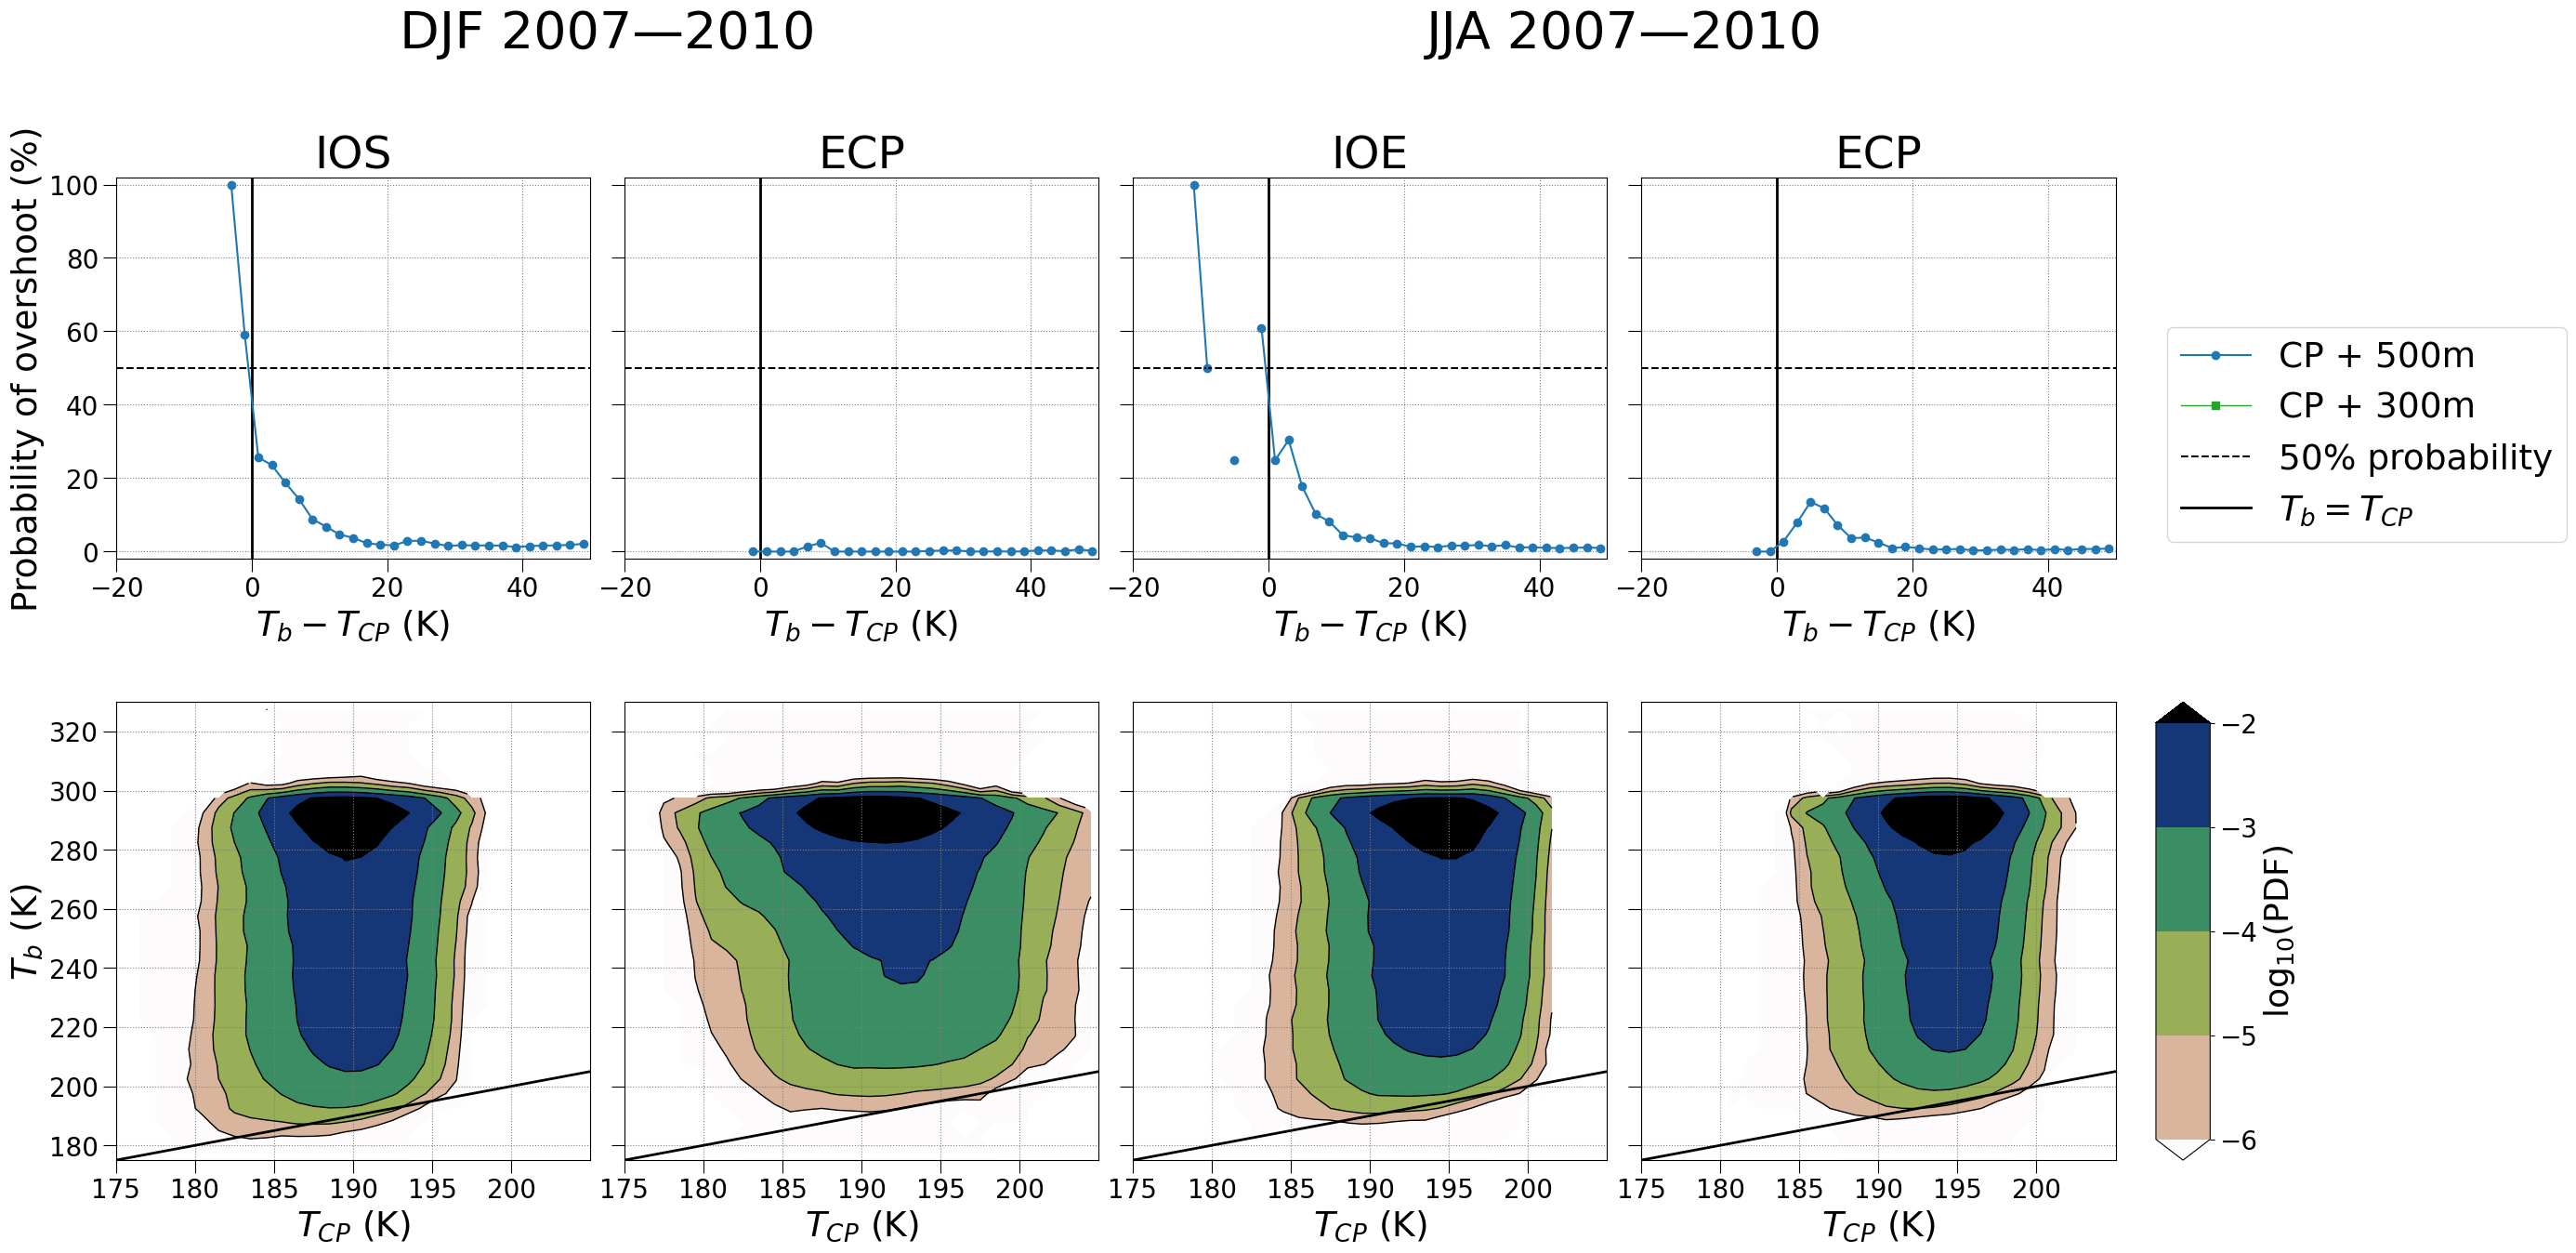

In [17]:
# SI
plot_prob_hist(season_hist_dict, season_prob500_dict, season_prob300_dict,
               diff_bins, years_str, save=True)
